In [1]:
import pandas as pd 
import numpy as np 
import requests 
import praw 
from collections import Counter 
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import regex as re
from  psaw import PushshiftAPI
import pickle
from datetime import datetime
import string
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [2]:
jan_word_soup=pd.read_pickle('WSB_Jan_Soup.pickle')
feb_word_soup=pd.read_pickle('WSB_Feb_Soup.pickle')
mar_word_soup=pd.read_pickle('WSB_Mar_Soup.pickle')
apr_word_soup=pd.read_pickle('WSB_Apr_Soup.pickle')
may_word_soup=pd.read_pickle('WSB_May_Soup.pickle')
jun_word_soup=pd.read_pickle('WSB_Jun_Soup.pickle')

soup_df=pd.concat([jan_word_soup, feb_word_soup, mar_word_soup, apr_word_soup, may_word_soup, jun_word_soup], axis=0, ignore_index=True)
soup_df.shape

(60911, 3)

In [28]:
sia = SentimentIntensityAnalyzer()
def vader_sentiment(review):
    vs = sia.polarity_scores(review)
    for senti,score in vs.items(): 
        if score > 0:
            return(senti)
sentiment=[]
for i in soup_df['text']:
    sentiment.append(vader_sentiment(i))
soup_df['sentiment']=sentiment


In [4]:
stock_list = pd.read_csv('/Users/jenniferhilibrand/Metis/Classification_ML/Stocks_list.csv')
ticker_list = list(stock_list['Symbol'])
lower_tickers=[]
for i in ticker_list:
    lower_tickers.append(i.lower())

In [92]:
def extract_ticker(string): 
    maybe_ticker=[]
    ticker=[]
    if string[0]=='$':
        new_string = string[1:]
        maybe_ticker.append(new_string.lower())
    if string.upper()==string:
        new_string = string.lower()
        maybe_ticker.append(new_string)
    else:
        pass
    for i in maybe_ticker: 
        if i in lower_tickers:
            ticker.append(i)
    return ticker

In [29]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

soup_df['text_clean'] = soup_df.text.map(alphanumeric).map(punc_lower)

In [30]:
corpus = soup_df['text_clean']
my_stop_words = ['www', 'reddit', 'com', 'https', '']
stop_words = ENGLISH_STOP_WORDS.union(my_stop_words)
#reddit_topic_matrix_df['month'] = pd.DatetimeIndex(reddit_topic_matrix_df['dates']).month

In [31]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
vectorizer = CountVectorizer(stop_words=stop_words)
doc_word = vectorizer.fit_transform(corpus)
doc_word.shape
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
fraud, robinhood, sec, just, market, short, hedge, like, people, gamestop

Topic  1
gme, shares, hold, just, like, stock, short, buy, sell, people

Topic  2
amc, gme, bb, nok, buy, moon, hold, bought, nbsp, tomorrow

Topic  3
days, gme, cover, capital, friday, melvin, short, day, covering, sell

Topic  4
gme, hold, buy, bb, rkt, nbsp, moon, nok, silver, line


In [32]:
vectorizer = CountVectorizer(stop_words = stop_words)
doc_word = vectorizer.fit_transform(corpus)
vectorizer = CountVectorizer(stop_words=stop_words)
doc_word = vectorizer.fit_transform(corpus)
tfidf = TfidfVectorizer(stop_words=stop_words)
reddit_word_matrix = tfidf.fit_transform(corpus)
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model.components_.round(5),
             index = ["component_1","component_2", "component_3","component_4","component_5"],
             columns = tfidf.get_feature_names())

display_topics(nmf_model, tfidf.get_feature_names(), 25)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
fraud, robinhood, sec, server, discord, media, social, important, posts, bloomberg, markets, hunts, drove, articles, integrity, gamestop, wallstreet, financial, news, securities, wallstreetbets, hateful, warnings, evidence, jail

Topic  1
like, just, stock, people, shares, don, buy, price, going, money, make, market, think, short, sell, want, buying, fucking, know, ve, funds, fuck, time, hedge, holding

Topic  2
amc, bb, buy, nok, moon, bought, today, holding, tomorrow, stocks, let, movies, nbsp, hedge, security, got, wish, time, br, shares, war, trading, clov, low, market

Topic  3
cover, days, short, friday, sell, melvin, day, capital, shorts, shares, fucking, squeeze, covering, week, ass, dildos, gonna, ratio, volume, need, million, shorted, number, position, starts

Topic  4
gme, hold, buy, bb, holding, moon, rkt, fucking, squeeze, nbsp, nok, today, line, let, silver, stocks, apes, financial, tomorrow, fuck, hands, wsb, edit, account, strong


In [33]:
vocab = tfidf.get_feature_names()
nmf_model.fit(reddit_word_matrix)
reddit_topic_matrix =  nmf_model.transform(reddit_word_matrix)
reddit_topic_matrix_df = pd.DataFrame(reddit_topic_matrix).add_prefix('topic_')
reddit_topic_matrix_df[['raw_comments', 'clean_comments', 'dates' , 'sentiment']] = soup_df[['text', 'text_clean', 'dates','sentiment']]
reddit_topic_matrix_df.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,topic_0,topic_1,topic_2,topic_3,topic_4,raw_comments,clean_comments,dates,sentiment
0,0.000008,0.007160,0.000703,0.027804,0.014917,**EDIT**: I asked the admins for an API endpoi...,edit i asked the admins for an api endpoi...,2021-01-27,neg
1,0.000000,0.000743,0.000053,0.001013,0.000821,"Wow, this. We're under attack.",wow this we re under attack,2021-01-27,neg
2,0.164829,0.000000,0.000000,0.000000,0.000000,[deleted],deleted,2021-01-27,neu
3,0.000027,0.004950,0.000804,0.004980,0.004972,This is a very good idea. Won't stop them all....,this is a very good idea won t stop them all ...,2021-01-27,neu
4,0.000026,0.003713,0.000314,0.003870,0.003059,"As a user with less than 1000 karma, I agree. ...",as a user with less than karma i agree my ...,2021-01-27,neg


In [34]:
primary_topic=[]
for i, row in reddit_topic_matrix_df.iterrows():
    topic_weights = [row.topic_0, row.topic_1, row.topic_2, row.topic_3, row.topic_4]
    max_val = max(topic_weights)
    max_index = topic_weights.index(max_val)
    primary_topic.append(max_index)
reddit_topic_matrix_df['primary_topic']= primary_topic
reddit_topic_matrix_df.groupby(['primary_topic', 'sentiment']).count()

topic_0  topic_1  topic_2  topic_3  topic_4  \
primary_topic sentiment                                                
0             neg             50       50       50       50       50   
              neu           2779     2779     2779     2779     2779   
              pos              4        4        4        4        4   
1             neg           8277     8277     8277     8277     8277   
              neu          13621    13621    13621    13621    13621   
              pos             64       64       64       64       64   
2             neg            643      643      643      643      643   
              neu            969      969      969      969      969   
              pos              1        1        1        1        1   
3             neg           5282     5282     5282     5282     5282   
              neu           7494     7494     7494     7494     7494   
              pos             64       64       64       64       64   
4             neg           8219     8219     8219     8219     8219   
              neu          13079    13079    13079    13079    13079   
              pos            235      235      235      235      235   

                         raw_comments  clean_comments  dates  
primary_topic sentiment                                       
0             neg                  50              50     50  
              neu                2779            2779   2779  
              pos                   4               4      4  
1             neg                8277            8277   8277  
              neu               13621           13621  13621  
              pos                  64              64     64  
2             neg                 643             643    643  
              neu                 969             969    969  
              pos                   1               1      1  
3             neg                5282            5282   5282  
              neu                7494            7494   7494  
              pos                  64              64     64  
4             neg                8219            8219   8219  
              neu               13079           13079  13079  
              pos                 235             235    235

In [35]:
month=[]
for i in reddit_topic_matrix_df['dates']:
    month.append(i.month)
reddit_topic_matrix_df['month']=month
export_df = reddit_topic_matrix_df

sentiment_score=[]

for i in export_df['sentiment']:
    if str(i).replace(" ","") == 'neg':
        sentiment_score.append(-5)
    if str(i).replace(" ","")== 'pos':
        sentiment_score.append(5) 
    if str(i).replace(" ","") == 'neu':
        sentiment_score.append(0)
    if i== None:
        sentiment_score.append(0)
        
export_df['sentiment_score']=sentiment_score

In [14]:
count_df = export_df.groupby(['primary_topic', 'month']).count()
sum_df = export_df.groupby(['primary_topic', 'month']).sum()

In [15]:
count_df.to_csv('/Users/jenniferhilibrand/Metis/NLP/WSB_df_count.csv', index=False)
sum_df.to_csv('/Users/jenniferhilibrand/Metis/NLP/WSB_df_sum.csv', index=False)

In [16]:
export_df['dates']=reddit_topic_matrix_df['dates']

In [36]:
daily_sentiment= export_df.groupby(['dates']).sum('sentiment_score')



In [18]:
sum(export_df['topic_2'])

172.30040171998075

In [19]:
sum(export_df['topic_3'])

421.8072954591463

In [20]:
reddit_topic_matrix_df.sort_values(by='topic_3', ascending=False)

,topic_0,topic_1,topic_2,topic_3,topic_4,raw_comments,clean_comments,dates,sentiment,primary_topic,month,sentiment_score
23751,0.0,0.000000,0.000000,0.227222,0.000000,I like this stock.,i like this stock,2021-02-02,neu,3,2,0
8774,0.0,0.000000,0.000000,0.227222,0.000000,WE LIKE THE STOCK! 🚀🚀🚀,we like the stock 🚀🚀🚀,2021-01-27,neu,3,1,0
499,0.0,0.000000,0.000000,0.227222,0.000000,WE LIKE THE STOCK,we like the stock,2021-01-27,neu,3,1,0
8564,0.0,0.000000,0.000000,0.227222,0.000000,WE LIKE THE STOCK,we like the stock,2021-01-27,neu,3,1,0
17609,0.0,0.000000,0.000000,0.227222,0.000000,i like this STOCK!,i like this stock,2021-02-03,neu,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
52424,0.0,0.003374,0.000000,0.000000,0.004999,LOADING UP WITH AUNT CATHIE ON THE $DKNG DIP!,loading up with aunt cathie on the dkng dip,2021-06-15,neu,4,6,0
15718,0.0,0.000000,0.000000,0.000000,0.117507,300 shares and holding bitches,shares and holding bitches,2021-01-31,neg,4,1,-5
6115,0.0,0.052482,0.000000,0.000000,0.036417,"Small time poor boy here, just did $100 in GME...",small time poor boy here just did in gme ...,2021-01-27,neg,1,1,-5
52427,0.0,0.003737,0.000058,0.000000,0.013563,"Anyone else loading up on $DKNG calls, let's g...",anyone else loading up on dkng calls let s g...,2021-06-15,neu,4,6,0


In [82]:
for comment in reddit_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)['raw_comments'].values:
    print(comment)
    print()

Buy more AMC/GME, hold until 🚀🚀🚀

Hold and buy more $AMC and $GME. We go to the moon.  **🚀🚀🚀**

Hold and buy more $AMC and $GME. We go to the moon.  **🚀🚀🚀**

HOLD YOUR AMC AND GME

HOLD GME AMC ETC

AMC - GME. HOLD!

hold GME and buy GME

HOLD GME BUY GME HOLD GME BUY GME HOLD GME BUY GME HOLD GME BUY GME HOLD GME BUY GME HOLD GME BUY GME

GME, BB, AMC HOLD

Hold BB AMC GME



In [ ]:
#wordcloud2 = WordCloud().generate(' '.join(list(reddit_topic_matrix_df['clean_comments'])))
#string_clean = str(clean)
wordcloud2 = WordCloud().generate(' '.join(list(clean)))
wordcloud2.recolor(color_func = random_color_func)
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(8)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
unclean = list(reddit_topic_matrix_df['clean_comments'])
clean=[]
total=[]
counter = 0
for i in unclean:
    new = i.split(' ')
    for j in new:
        counter+=1
        total.append(j)
        if len(j)<2:
            pass
        else:
            clean.append(j)
len(clean)
len(set(total))

38729

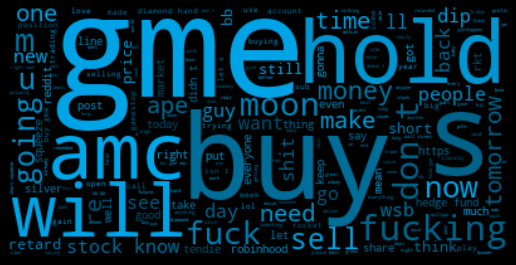

In [87]:


#change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(120, 0%%, %d%%)" % np.random.randint(60, 100)


def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 140 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)



wordcloud2 = WordCloud().generate(' '.join(list(reddit_topic_matrix_df[reddit_topic_matrix_df['primary_topic']==1]['clean_comments'])))
wordcloud2.recolor(color_func = random_color_func)

f = plt.figure()
f.set_figwidth(9)
f.set_figheight(8)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
list(reddit_topic_matrix_df[reddit_topic_matrix_df['primary_topic']==1]['clean_comments'])

In [74]:
monthly_by_avg_topic_sentiment= export_df.groupby(['month', 'primary_topic']).mean('sentiment_score')
monthly_by_avg_topic_sentiment.to_csv('/Users/jenniferhilibrand/Metis/NLP/WSB_avg_topic_monthly_sentiment.csv', index=False)
monthly_by_topic_sentiment=export_df.groupby(['month', 'primary_topic']).count()
monthly_by_topic_sentiment.to_csv('/Users/jenniferhilibrand/Metis/NLP/WSB_topic_monthly_sentiment.csv', index=False)


In [79]:
daily_topic_sum = export_df.groupby(['dates']).sum(['topic_0', 'topic_1', 'topic_2','topic_3','topic_4'])
daily_topic_sum.to_csv('/Users/jenniferhilibrand/Metis/NLP/WSB_daily_topic.csv')

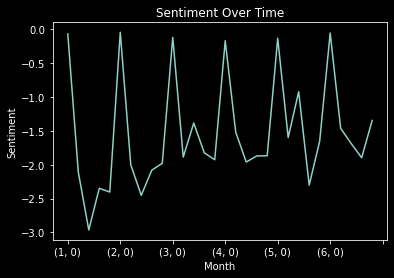

In [66]:
sentiment_Score = daily_sentiment['sentiment_score']
sentiment_Score.plot()
plt.xlabel("Month")
plt.ylabel("Sentiment")
plt.title("Sentiment Over Time")
plt.style.use('dark_background')
plt.show()

In [56]:
sentiment_Score[0:6]

month
1   -2.120770
2   -1.935448
3   -1.789001
4   -1.700518
5   -1.635552
6   -1.433799
Name: sentiment_score, dtype: float64

In [60]:
from sklearn.decomposition import LatentDirichletAllocation

count_vectorizer = CountVectorizer(min_df=10, max_df=0.95, ngram_range=(1,1), stop_words='english')

feature_matrix = count_vectorizer.fit_transform(corpus)

# Instantiate the LDA model
lda_model = LatentDirichletAllocation(n_components=2, max_iter=100, learning_method='online', random_state=43,
                                     batch_size=128, evaluate_every=-1, n_jobs=-1)


# fit transform the feature matrix
lda_output = lda_model.fit_transform(feature_matrix)

# display the lda_output and its shape
display(lda_output)
display(lda_output.shape)

array([[0.59786358, 0.40213642],
       [0.66034143, 0.33965857],
       [0.74999312, 0.25000688],
       ...,
       [0.83141329, 0.16858671],
       [0.90752127, 0.09247873],
       [0.25135463, 0.74864537]])

(60911, 2)

In [61]:
# print log-likelihood
print("Log likelihood: ", lda_model.score(feature_matrix))

Log likelihood:  -3619993.941057845


In [62]:
# print perplexity
print("Perplexity: ", lda_model.perplexity(feature_matrix))

Perplexity:  1458.4884181964342


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [2, 25], 'learning_decay': [.5, .9]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params)

model.fit(feature_matrix)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(feature_matrix))

In [ ]:
import seaborn as sns
df_cv_results = pd.DataFrame(model.cv_results_)
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

In [ ]:
lda_output = best_lda_model.transform(feature_matrix)
topicnames = ['Topic_' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc_' + str(i) for i in range(len(clean_reviews_text))]

# create a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,2), columns=topicnames, index=docnames)

df_document_topic.head()

In [89]:
wsb_titles=pd.read_pickle('WSB_titles_only.pickle')
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

wsb_titles['text_clean'] = wsb_titles.text.map(alphanumeric).map(punc_lower)

In [162]:
titles_corpus = wsb_titles['text_clean']
wsb_titles.head(5)

,text,timestamp,dates,text_clean,tickers
0,COULDN’T POSSIBLY BE HEDGE FUNDS 💎👐💎,2021-02-03 14:54:00,2021-02-03,couldn’t possibly be hedge funds 💎👐💎,[be]
1,My 102 year old grandmother bought GME in Augu...,2021-02-02 08:29:24,2021-02-02,my year old grandmother bought gme in august...,[gme]
2,who else bought at $250+,2021-02-04 12:56:48,2021-02-04,who else bought at,[]
3,Who of my 300 brethren's are still in ?,2021-02-03 03:54:46,2021-02-03,who of my brethren s are still in,[]
4,APES IN CONTROL,2021-02-02 13:01:05,2021-02-02,apes in control,[]


In [103]:
ticker_list=[]
for i in wsb_titles['text']:
    tickers=[]
    words = i.split()
    for j in words:
        tickers.extend(extract_ticker(j))
    ticker_list.append(tickers)
        
wsb_titles['tickers']=ticker_list

In [111]:
vectorizer = CountVectorizer(stop_words=stop_words)
doc_word = vectorizer.fit_transform(titles_corpus)
tfidf = TfidfVectorizer(stop_words=stop_words)
reddit_title_matrix = tfidf.fit_transform(titles_corpus)
nmf_model_title = NMF(5)
doc_topic = nmf_model_title.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model_title.components_.round(5),
             index = ["component_1","component_2", "component_3","component_4","component_5"],
             columns = tfidf.get_feature_names())

display_topics(nmf_model_title, tfidf.get_feature_names(), 10)


Topic  0
sell, don, want, dont, friday, fucking, let, holding, squeeze, gas

Topic  1
gme, amc, bb, moon, buy, going, stay, holding, lets, shares

Topic  2
hold, need, bots, old, buy, hoooold, cover, line, listen, let

Topic  3
hedge, stock, fuck, funds, wsb, stop, market, going, gamestop, price

Topic  4
just, like, day, short, looks, wall, week, stock, mp, btw


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [156]:
with open('/Users/jenniferhilibrand/Metis/NLP/reddit_topic_matrix.pickle', 'wb') as to_save:
    pickle.dump(reddit_topic_matrix_df ,to_save) 

In [152]:
##generate new topic model to test for distance from input, from existing comments
word = 'citadel'
reddit_topic_matrix_df2 = reddit_topic_matrix_df
clean_comments = list(reddit_topic_matrix_df2['clean_comments'])
clean_comments.append(word)
corpus_new=clean_comments

vectorizer = CountVectorizer(stop_words = stop_words)
doc_word = vectorizer.fit_transform(corpus_new)
tfidf = TfidfVectorizer(stop_words=stop_words)
reddit_word_matrix2 = tfidf.fit_transform(corpus_new)

doc_topic = nmf_model.fit_transform(doc_word)
topic_word = pd.DataFrame(nmf_model.components_.round(5),
             index = ["component_1","component_2", "component_3","component_4","component_5"],
             columns = tfidf.get_feature_names())
nmf_model.fit(reddit_word_matrix2)
reddit_topic_matrix =  nmf_model.transform(reddit_word_matrix2)
reddit_topic_matrix_df2 = pd.DataFrame(reddit_topic_matrix).add_prefix('topic_')



reddit_topic_matrix_df2['comments']=clean_comments
distance_matrix=reddit_topic_matrix_df2 .set_index('comments')
distance_matrix.tail(5)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,topic_0,topic_1,topic_2,topic_3,topic_4
comments,,,,,
what happened,0.000030,0.000804,0.000160,0.001014,0.000882
nice guy finishes last,0.000014,0.001287,0.000076,0.002241,0.001829
great scene but not really following your meme here,0.000004,0.002330,0.000442,0.005954,0.002109
amc is a distraction from gme amc is literally owned by citadel,0.000000,0.063614,0.000000,0.000000,0.000000
citadel,0.000003,0.001034,0.000163,0.000692,0.000512


In [153]:
input_row = distance_matrix.tail(1)

dist_list=[]
for index, row in distance_matrix.iterrows():
    dist_list.append(np.linalg.norm(row - input_row))
    
recommender_df = pd.DataFrame(dist_list)
recommender_df['comments']=clean_comments
top = recommender_df.sort_values(by=[0])



In [160]:
similar_comments = top['comments'][1:101]
sentiment_similar=[]
for i in similar_comments:
    sentiment_similar.append(vader_sentiment(i))
senti_count=Counter(sentiment_similar)
print(senti_count['neg'], '% negative')

25 % negative


In [161]:
for i in similar_comments[0:10]:
    print(i)

its citadel
take my dollar and shut up 
all it needs to do is leave the pad   
aso anout to rocket
shutup hedgie and go back to citadel  tell them you failed 
there should be universal hatred for the high finance industry
yes  and sometimes they have the story written and published beforehand   
you should diversify incase starbucks goes under  get some chili s and walmart ones too 
how do you even sleep when your whole portfolio is burnt
if you’re dumb enough to still be on robin hood that is 
